In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sliced.datasets import make_cubic
from sliced import SlicedInverseRegression
from sliced import SlicedAverageVarianceEstimation
from sliced import datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import math

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')

# Generate X Y

In [3]:
x1Restruct_Fun=np.zeros([603,3408])
x2Restruct_Fun=np.zeros([603,5112])

#x1 (0th~1703th column as x)
for i in range (0,603):
    for j in range (0,71):
        a=np.array(data['pm25_obs'][5112*i+72*j:5112*i+72*j+48])
        for k in range (0,48):
            x1Restruct_Fun[i][j*48+k]=a[k]

#x2 (1704th~8520th column as x)
for i in range (2,605):
    b=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    for j in range(0,5112):
        x2Restruct_Fun[i-2][j]=b[j]
        
print(np.shape(x1Restruct_Fun))
print(np.shape(x2Restruct_Fun))

(603, 3408)
(603, 5112)


In [4]:
YRestruct_Fun=np.zeros([600,5112])
for j in range (0,71):
    for i in range(0,600):
        YRestruct_Fun[i][72*j:72*j+24]=x1Restruct_Fun[1+i][48*j+24:48*j+48]
        YRestruct_Fun[i][72*j+24:72*j+48]=x1Restruct_Fun[1+i+1][48*j+24:48*j+48]
        YRestruct_Fun[i][72*j+48:72*j+72]=x1Restruct_Fun[1+i+2][48*j+24:48*j+48]
print(np.shape(YRestruct_Fun))

(600, 5112)


In [5]:
XRestruct_Fun=np.zeros([600,8520])
for i in range (0,600):
    for j in range (0,3408):
        XRestruct_Fun[i][j]=x1Restruct_Fun[i][j]
    for j in range (3408,8520):
        XRestruct_Fun[i][j]=x2Restruct_Fun[i][j-3408]
print(np.shape(XRestruct_Fun))

(600, 8520)


In [6]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([539,8520])
Yhat_train = np.zeros([539,5112])

for i in range (1,540):
    for j in range (0,3408):
        Xhat_train[i-1][j] = Xhat[i][j]
    for j in range (0,5112):    
        Xhat_train[i-1][j+3408] = Xhat[i][j+3408]
        Yhat_train[i-1][j] = Yhat[i][j]

In [7]:
###
#cal_PMf  
###
XR=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    XR[i]=a.T

###
#obs_PMf
###
YR=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_obs'][5112*i:5112*i+5112])
    YR[i]=a.T
    
Xh=XR
Yh=YR
Xhat_val = np.zeros([61,8520])
Yhat_val = np.zeros([61,5112])
Xhat_test = np.zeros([61,8520])
Yhat_test = np.zeros([61,5112])
        
for i in range (544,605):
    for j in range (0,71):
        a=np.array(data['pm25_obs'][5112*(i-1)+72*j:5112*(i-1)+72*j+48])
        for k in range (0,48):
            Xhat_val[i-544][j*48+k]=a[k]
    for j in range (0,5112):
        Xhat_val[i-544][3408+j] = Xh[i][j]
        Yhat_val[i-544][j] = Yh[i][j]     
        
for i in range (544,605):
    for j in range (0,71):
        a=np.array(data['pm25_obs'][5112*(i-1)+72*j:5112*(i-1)+72*j+48])
        for k in range (0,48):
            Xhat_test[i-544][j*48+k]=a[k]
    for j in range (0,5112):
        Xhat_test[i-544][3408+j] = Xh[i][j]
        Yhat_test[i-544][j] = Yh[i][j]  

In [8]:
print('Xhat_train')
print(np.shape(Xhat_train))
print('Yhat_train')
print(np.shape(Yhat_train))
print('Xhat_val')
print(np.shape(Xhat_val))
print('Yhat_val')
print(np.shape(Yhat_val))
print('Xhat_test')
print(np.shape(Xhat_test))
print('Yhat_test')
print(np.shape(Yhat_test))

Xhat_train
(539, 8520)
Yhat_train
(539, 5112)
Xhat_val
(61, 8520)
Yhat_val
(61, 5112)
Xhat_test
(61, 8520)
Yhat_test
(61, 5112)


## Sparse and Expend data

In [10]:
X1hat_train = np.zeros([539,3408])
X2hat_train = np.zeros([539,5112])
X1hat_test = np.zeros([61,3408])
X2hat_test = np.zeros([61,5112])
for i in range (0,539):
    for j in range (0,3408):
        X1hat_train[i][j] = Xhat_train[i][j]
    for j in range (3408,8520):
        X2hat_train[i][j-3408] = Xhat_train[i][j]
for i in range (0,61):
    for j in range (0,3408):
         X1hat_test[i][j] = Xhat_test[i][j]   
    for j in range (3408,8520):
        X2hat_test[i][j-3408] = Xhat_test[i][j]
print('X1hat_train')
#print(X1hat_train)
print(np.shape(X1hat_train))
print('X2hat_train')
#print(X2hat_train)
print(np.shape(X2hat_train))
print('X1hat_test')
#print(X1hat_test)
print(np.shape(X1hat_test))
print('X2hat_test')
#print(X2hat_test)
print(np.shape(X2hat_test))

X1hat_train
(539, 3408)
X2hat_train
(539, 5112)
X1hat_test
(61, 3408)
X2hat_test
(61, 5112)


In [11]:
new_x=np.zeros([539*72,8520]) #38880
new_y=np.zeros([539*72,5112]) #38880
#new_x : 0th~3408th column
for i in range (0,72):
    for j in range (0,539):
        for k in range (0,3408):
            new_x[539*i+j][k]=X1hat_train[j][k]
#new_x : 3408th~8519th column
for i in range (0,72):
    for j in range (0,539):
        for k in range (0+i,5040+1+i,72): #5040=5112-72
            new_x[539*i+j][3408+k]=X2hat_train[j][k]
#new_y
for i in range (0,72):
    for j in range (0,539):
        for k in range (0,5112):
            new_y[539*i+j][k]=YRestruct_Fun[j][k]         

print(np.shape(new_x))
print(np.shape(new_y))

(38808, 8520)
(38808, 5112)


In [12]:
new_exx=np.zeros([61*72,8520]) #38880
new_eyy=np.zeros([61*72,5112]) #38880
#new_exx : 0th~3408th column
for i in range (0,72):
    for j in range (0,61):
        for k in range (0,3408):
            new_exx[61*i+j][k]=X1hat_test[j][k]
#new_exx : 3408th~8520th column
for i in range (0,72):
    for j in range (0,61):
        for k in range (0+i,5040+1+i,72): #5040=5112-72
            new_exx[61*i+j][3408+k]=X2hat_test[j][k]
#new_eyy
for i in range (0,72):
    for j in range (0,61):
        for k in range (0,5112):
            new_eyy[61*i+j][k]=Yhat_test[j][k]         

print(np.shape(new_exx))
print(np.shape(new_eyy))

(4392, 8520)
(4392, 5112)


# Original Data

In [13]:
error1 = mean_absolute_error(Xhat_test[:,3408:], Yhat_test)
error2 = mean_squared_error(Xhat_test[:,3408:], Yhat_test)
print('testing data MAE is ',error1)
print('testing data MAE is ',error2)

testing data MAE is  6.919742865451666
testing data MAE is  90.30246788296535


# Mix Model

## 公式解（PCA + Linear regression）

In [14]:
x = new_x
y = new_y
xt = new_exx
yt = Yhat_test

In [15]:
xper = np.zeros(5)
xper[0] = 0.85
xper[1] = 0.9
xper[2] = 0.95
xper[3] = 0.99
xper[4] = 0.995
yper = xper
test_error_MAE = 100*np.ones(25)
test_error_MSE = 100*np.ones(25)
MAE_index=[]
MSE_index=[]

In [16]:
for z in range (0,5):
    for w in range (0,5):
        pca_x = PCA(n_components=xper[z])
        pca_x.fit(x)
        x_pca=pca_x.transform(x)
        
        pca_y = PCA(n_components=yper[w])
        pca_y.fit(y)
        y_pca=pca_y.transform(y)
        
        model = LinearRegression()
        model.fit(x_pca, y_pca)

        xt_pca = pca_x.transform(xt)
        fit_x = model.predict(xt_pca)
        fit = pca_y.inverse_transform(fit_x)
        fit95 = np.zeros([61,5112])
        for i in range (0,72):
            for j in range (0,61):
                for k in range (0,71):
                    fit95[j][72*k+i]=fit[61*i+j][72*k+i]
        mae = np.mean(abs(fit95-yt))
        mse = np.mean((fit95-yt)**2)
        test_error_MAE[z*5+w] = mae
        test_error_MSE[z*5+w] = mse
        MAE_index.append((xper[z], yper[w], mae))
        MSE_index.append((xper[z], yper[w], mse))

In [17]:
f1 = np.argmin(test_error_MAE)
f2 = np.argmin(test_error_MSE)
print('test data on x = ', 100*MAE_index[f1][0], '% Y = ', 100*MAE_index[f1][1], '% have the min MAE error :', min(test_error_MAE))
print(MAE_index[f1])
print('test data on x = ', 100*MSE_index[f2][0], '% Y = ', 100*MSE_index[f2][1], '% have the min MSE error :', min(test_error_MSE))
print(MSE_index[f2])

test data on x =  90.0 % Y =  95.0 % have the min MAE error : 4.716366870073052
(0.9, 0.95, 4.716366870073052)
test data on x =  90.0 % Y =  95.0 % have the min MSE error : 42.3013281996281
(0.9, 0.95, 42.3013281996281)


## Gradient descent (loss = MAE)

In [18]:
x1 = X1hat_train
x2 = X2hat_train
y = Yhat_train
xt1 = X1hat_test
xt2 = X2hat_test
yt = Yhat_test

In [19]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + x2*b2
    return y

In [20]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)


beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([3408,5112], requires_grad = True)
beta2 = torch.zeros(5112, requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)

epo = 500
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)

for epoch in range (epo):
    yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
    test_error_MAE[epoch] = torch.mean(torch.abs(yhats_test - y_test))
    test_error_MSE[epoch] = torch.mean((yhats_test - y_test)**2)

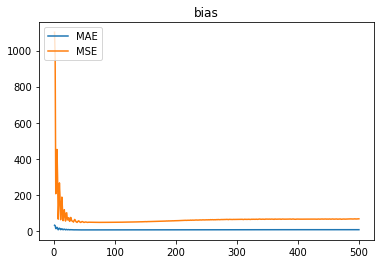

In [21]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('bias')

plt.show()

In [22]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  4.9191903117934395
testing data MAE is  46.44827520161824


## Gradient descent (loss = MSE)

In [23]:
x1 = X1hat_train
x2 = X2hat_train
y = Yhat_train
xt1 = X1hat_test
xt2 = X2hat_test
yt = Yhat_test

In [24]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + x2*b2
    return y

In [25]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)


beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([3408,5112], requires_grad = True)
beta2 = torch.zeros(5112, requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)

epo = 500
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)

for epoch in range (epo):
    yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
    test_error_MAE[epoch] = torch.mean(torch.abs(yhats_test - y_test))
    test_error_MSE[epoch] = torch.mean((yhats_test - y_test)**2)

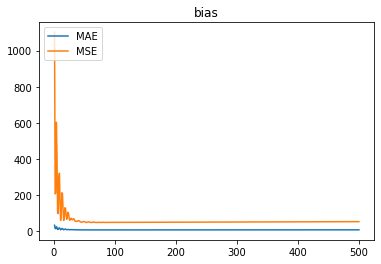

In [26]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('bias')

plt.show()

In [27]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  4.968147724714406
testing data MAE is  46.16961264238723


## Gradient descent (loss = Huber loss)

In [28]:
x1 = X1hat_train
x2 = X2hat_train
y = Yhat_train
xt1 = X1hat_test
xt2 = X2hat_test
yt = Yhat_test

In [29]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + x2*b2
    return y

In [30]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)


beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([3408,5112], requires_grad = True)
beta2 = torch.zeros(5112, requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)

epo = 500
loss = nn.HuberLoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)

for epoch in range (epo):
    yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
    test_error_MAE[epoch] = torch.mean(torch.abs(yhats_test - y_test))
    test_error_MSE[epoch] = torch.mean((yhats_test - y_test)**2)

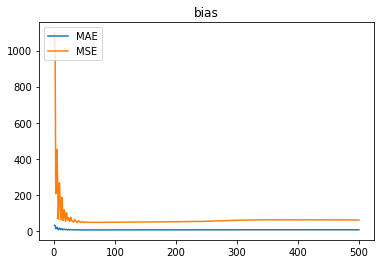

In [31]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('bias')

plt.show()

In [32]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  4.912252252854086
testing data MAE is  46.289773509318586


# Function on Function Model

## 公式解（PCA + Linear regression）

In [33]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [34]:
xper = np.zeros(5)
xper[0] = 0.85
xper[1] = 0.9
xper[2] = 0.95
xper[3] = 0.99
xper[4] = 0.995
yper = xper
test_error_MAE = 100*np.ones(25)
test_error_MSE = 100*np.ones(25)
MAE_index=[]
MSE_index=[]

In [35]:
for z in range (0,5):
    for w in range (0,5):
        pca_x = PCA(n_components=xper[z])
        pca_x.fit(x)
        x_pca=pca_x.transform(x)
        
        pca_y = PCA(n_components=yper[w])
        pca_y.fit(y)
        y_pca=pca_y.transform(y)
        
        model = LinearRegression()
        model.fit(x_pca, y_pca)

        xt_pca = pca_x.transform(xt)
        fit_x = model.predict(xt_pca)
        fit = pca_y.inverse_transform(fit_x)
        
        mae = np.mean(abs(fit-yt))
        mse = np.mean((fit-yt)**2)
        test_error_MAE[z*5+w] = mae
        test_error_MSE[z*5+w] = mse
        MAE_index.append((xper[z], yper[w], mae))
        MSE_index.append((xper[z], yper[w], mse))

In [36]:
f1 = np.argmin(test_error_MAE)
f2 = np.argmin(test_error_MSE)
print('test data on x = ', 100*MAE_index[f1][0], '% Y = ', 100*MAE_index[f1][1], '% have the min MAE error :', min(test_error_MAE))
print(MAE_index[f1])
print('test data on x = ', 100*MSE_index[f2][0], '% Y = ', 100*MSE_index[f2][1], '% have the min MSE error :', min(test_error_MSE))
print(MSE_index[f2])

test data on x =  85.0 % Y =  85.0 % have the min MAE error : 5.132948519211088
(0.85, 0.85, 5.132948519211088)
test data on x =  85.0 % Y =  85.0 % have the min MSE error : 44.770081245746844
(0.85, 0.85, 44.770081245746844)


## Gradient descent (loss = MAE)

In [37]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [38]:
def model (x,b0,b1):
    y = b0 +  torch.matmul(x , b1)
    return y

In [39]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([8520,5112], requires_grad = True)

rate = 1e-4
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 500
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

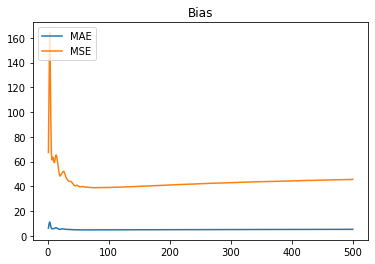

In [40]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [41]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  4.712326756954634
testing data MAE is  38.847238020876105


## Gradient descent (loss = MSE)

In [42]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [43]:
def model (x,b0,b1):
    y = b0 +  torch.matmul(x , b1)
    return y

In [44]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([8520,5112], requires_grad = True)

rate = 1e-4
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 500
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

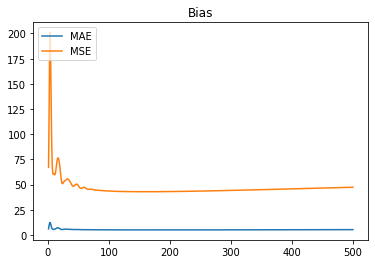

In [45]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [46]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.037199952172214
testing data MAE is  42.944046902086605


## Gradient descent (loss = Huber loss)

In [47]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [48]:
def model (x,b0,b1):
    y = b0 +  torch.matmul(x , b1)
    return y

In [49]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([8520,5112], requires_grad = True)

rate = 1e-4
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 500
loss = nn.HuberLoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

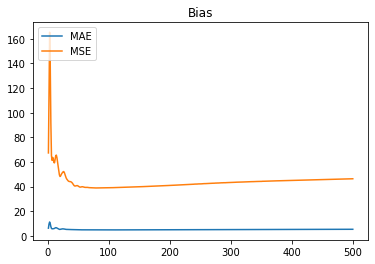

In [50]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [51]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  4.710140761803895
testing data MAE is  38.81117992002286


# PLS Model

In [52]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [53]:
test_error_MAE = 100*np.ones(50)
test_error_MSE = 100*np.ones(50)
for n in range (1,51):
    model = PLSRegression(n_components=n,max_iter=1000)
    model.fit(x, y)

    xf=Xhat_test
    xfit=model.predict(xf)
    
    after_MAE=np.nanmean(abs(xfit-yt))
    after_MSE=np.nanmean((xfit-yt)**2)
    
    test_error_MAE[n-1] = after_MAE
    test_error_MSE[n-1] = after_MSE

In [54]:
print('test data on n = ', np.argmin(test_error_MAE)+1, 'have the min MAE error : ', min(test_error_MAE))
print('test data on n = ', np.argmin(test_error_MSE)+1, 'have the min MSE error : ', min(test_error_MSE))

test data on n =  10 have the min MAE error :  5.083056030505807
test data on n =  10 have the min MSE error :  43.894682160420246


# SIR Model

In [55]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [56]:
xper = np.zeros(5)
xper[0] = 0.85
xper[1] = 0.90
xper[2] = 0.95
xper[3] = 0.99
xper[4] = 0.995
yper = np.zeros(3)
yper[0] = 0.95
yper[1] = 0.99
yper[2] = 0.995
slices = np.zeros(5)
slices[0] = 10
slices[1] = 20
slices[2] = 30
slices[3] = 40
slices[4] = 50
test_error_MAE = 100*np.ones(15)
test_error_MSE = 100*np.ones(15)
index_MAE = []
index_MSE = []

In [57]:
for q in range (0,5):
    for r in range(0,3):
        pca_x = PCA(n_components=xper[q])
        pca_x.fit(x)
        x_pca=pca_x.transform(x)
        a = x_pca.shape[1]

        pca_y = PCA(n_components=yper[r])
        pca_y.fit(y)
        y_pca=pca_y.transform(y)
        b = y_pca.shape[1]

        xt_pca=pca_x.transform(xt)

        xt_svr = np.zeros([5,61,b])
        #5是因為有5種n_slices
        for j in range (0,5):
            for i in range (0,b):
                sir_x = SlicedInverseRegression(n_slices=slices[j])
                sir_x.fit(x_pca, y_pca[:,i])
                x_sir = sir_x.transform(x_pca)
                   
                svr = SVR()
                svr.fit(x_sir, y_pca[:,i])
                
                xt_sir = sir_x.transform(xt_pca) 
                xt_svr[j][:,i]=svr.predict(xt_sir)
        error1 = np.zeros(5)
        error2 = np.zeros(5)
        for i in range (0,5):
            yt_inv = pca_y.inverse_transform(xt_svr[i])
            error1[i] = np.mean(abs(yt_inv-yt))
            error2[i] = np.mean((yt_inv-yt)**2)

        n1 = 10*(np.argmin(error1)+1)
        n2 = 10*(np.argmin(error2)+1)
        min1 = min(error1)
        min2 = min(error2)
        index_MAE.append((xper[q], yper[r], n1, min1))    
        index_MSE.append((xper[q], yper[r], n2, min2)) 
        test_error_MAE[3*q+r] = min1
        test_error_MSE[3*q+r] = min2

In [58]:
f1 = np.argmin(test_error_MAE)
f2 = np.argmin(test_error_MSE)
print('test data on n_slices = ', index_MAE[f1][2], ', x = ', index_MAE[f1][0], '% , y = ', index_MAE[f1][1], '% have the min MAE error :', min(test_error_MAE))
print(index_MAE[f1])
print('test data on n_slices = ', index_MSE[f2][2], ', x = ', index_MSE[f2][0], '% , y = ', index_MSE[f2][1], '% have the min MSE error :', min(test_error_MSE))
print(index_MSE[f2])

test data on n_slices =  10 , x =  0.85 % , y =  0.95 % have the min MAE error : 5.2464865769652365
(0.85, 0.95, 10, 5.2464865769652365)
test data on n_slices =  10 , x =  0.85 % , y =  0.95 % have the min MSE error : 46.74888696351532
(0.85, 0.95, 10, 46.74888696351532)


# CNN Model

In [59]:
Xhat_train_n = np.zeros([71,539,120])
Yhat_train_n = np.zeros([71,539,72])
Xhat_test_n = np.zeros([71,61,120])
Yhat_test_n = np.zeros([71,61,72])
for i in range (0,71):
    for j in range (0,539):
        for k in range (0,48):
            Xhat_train_n[i][j][k] = Xhat_train[j][48*i+k]
        for k in range (0,72):
            Xhat_train_n[i][j][k+48] = Xhat_train[j][3408+(72*i)+k]
            Yhat_train_n[i][j][k] = Yhat_train[j][(72*i)+k]
    for j in range (0,61):
        for k in range (0,48):
            Xhat_test_n[i][j][k] = Xhat_test[j][48*i+k]
        for k in range (0,72):
            Xhat_test_n[i][j][k+48] = Xhat_test[j][3408+(72*i)+k]
            Yhat_test_n[i][j][k] = Yhat_test[j][(72*i)+k]
print('Xhat_train')
print(np.shape(Xhat_train_n))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n))
print('Yhat_test')
print(np.shape(Yhat_test_n))
Xhat_val=Xhat_test_n
Yhat_val=Yhat_test_n
print('Xhat_val')
print(np.shape(Xhat_val))
print('Yhat_val')
print(np.shape(Yhat_val))

Xhat_train
(71, 539, 120)
Yhat_train
(71, 539, 72)
Xhat_test
(71, 61, 120)
Yhat_test
(71, 61, 72)
Xhat_val
(71, 61, 120)
Yhat_val
(71, 61, 72)


## loss = MAE

In [60]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv1d(1 , 32 , 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(32 , 32 , 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Conv1d(32, 32 , 2)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv1d(32 , 32 , 2)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv1d(32 , 32 , 2)
        self.act5 = nn.ReLU()
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(115*32,264)
        self.fc2 = nn.Linear(264,72)
    
    def forward(self, x): 
        ouput = torch.unsqueeze(x,1)
        ouput = self.act1(self.layer1(ouput))
        ouput = self.act2(self.layer2(ouput))
        ouput = self.act3(self.layer3(ouput))
        ouput = self.act4(self.layer4(ouput))
        ouput = self.act5(self.layer5(ouput))
        ouput = self.fl(ouput)
        ouput = self.fc1(ouput)
        ouput = self.fc2(ouput)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val[i]).float()
    y_val = torch.from_numpy(Yhat_val[i]).float()
    
    logger = CSVLogger("CNN Model2", name="CNN_120hr_MAE")
    model = CNN() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [62]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/CNN Model2/CNN_120hr_MAE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

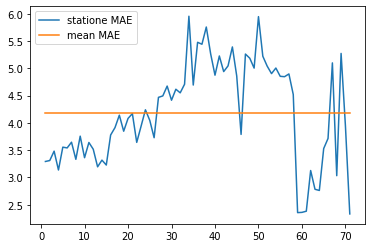

In [63]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

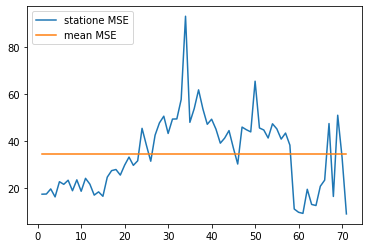

In [64]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [65]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  4.181209473542764
testing data MAE is  34.52330056042739


## loss = MSE

In [66]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv1d(1 , 32 , 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(32 , 32 , 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Conv1d(32, 32 , 2)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv1d(32 , 32 , 2)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv1d(32 , 32 , 2)
        self.act5 = nn.ReLU()
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(115*32,264)
        self.fc2 = nn.Linear(264,72)
    
    def forward(self, x): 
        ouput = torch.unsqueeze(x,1)
        ouput = self.act1(self.layer1(ouput))
        ouput = self.act2(self.layer2(ouput))
        ouput = self.act3(self.layer3(ouput))
        ouput = self.act4(self.layer4(ouput))
        ouput = self.act5(self.layer5(ouput))
        ouput = self.fl(ouput)
        ouput = self.fc1(ouput)
        ouput = self.fc2(ouput)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val[i]).float()
    y_val = torch.from_numpy(Yhat_val[i]).float()
    
    logger = CSVLogger("CNN Model2", name="CNN_120hr_MSE")
    model = CNN() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [68]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/CNN Model2/CNN_120hr_MSE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

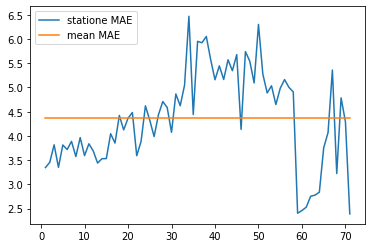

In [69]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

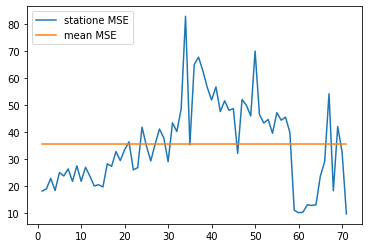

In [70]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [71]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  4.362375773174662
testing data MAE is  35.26607520143751


## loss = Huber loss

In [72]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv1d(1 , 32 , 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(32 , 32 , 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Conv1d(32, 32 , 2)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv1d(32 , 32 , 2)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv1d(32 , 32 , 2)
        self.act5 = nn.ReLU()
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(115*32,264)
        self.fc2 = nn.Linear(264,72)
    
    def forward(self, x): 
        ouput = torch.unsqueeze(x,1)
        ouput = self.act1(self.layer1(ouput))
        ouput = self.act2(self.layer2(ouput))
        ouput = self.act3(self.layer3(ouput))
        ouput = self.act4(self.layer4(ouput))
        ouput = self.act5(self.layer5(ouput))
        ouput = self.fl(ouput)
        ouput = self.fc1(ouput)
        ouput = self.fc2(ouput)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val[i]).float()
    y_val = torch.from_numpy(Yhat_val[i]).float()
    
    logger = CSVLogger("CNN Model2", name="CNN_120hr_Huber")
    model = CNN() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [74]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/CNN Model2/CNN_120hr_Huber/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

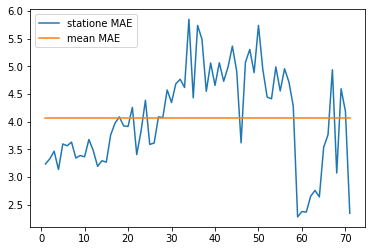

In [75]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

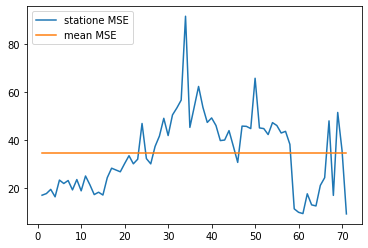

In [76]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [77]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  4.0743620194179915
testing data MAE is  34.366706283999164


# Transformer Model

In [13]:
Xhat_train_n = np.zeros([71,539,120])
Yhat_train_n = np.zeros([71,539,72])
Xhat_test_n = np.zeros([71,61,120])
Yhat_test_n = np.zeros([71,61,72])
for i in range (0,71):
    for j in range (0,539):
        for k in range (0,48):
            Xhat_train_n[i][j][k] = Xhat_train[j][48*i+k]
        for k in range (0,72):
            Xhat_train_n[i][j][k+48] = Xhat_train[j][3408+(72*i)+k]
            Yhat_train_n[i][j][k] = Yhat_train[j][(72*i)+k]
    for j in range (0,61):
        for k in range (0,48):
            Xhat_test_n[i][j][k] = Xhat_test[j][48*i+k]
        for k in range (0,72):
            Xhat_test_n[i][j][k+48] = Xhat_test[j][3408+(72*i)+k]
            Yhat_test_n[i][j][k] = Yhat_test[j][(72*i)+k]
print('Xhat_train')
print(np.shape(Xhat_train_n))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n))
print('Yhat_test')
print(np.shape(Yhat_test_n))
Xhat_val_n=Xhat_test_n
Yhat_val_n=Yhat_test_n
print('Xhat_val')
print(np.shape(Xhat_val_n))
print('Yhat_val')
print(np.shape(Yhat_val_n))

Xhat_train
(71, 540, 120)
Yhat_train
(71, 540, 72)
Xhat_test
(71, 61, 120)
Yhat_test
(71, 61, 72)
Xhat_val
(71, 61, 120)
Yhat_val
(71, 61, 72)


In [23]:
Xhat_train_n0 = np.zeros([71, 539, 192])
Xhat_val_n0 = np.zeros([71, 61, 192])
Xhat_test_n0 = np.zeros([71, 61, 192])
for k in range(0,71):
    for i in range (0,539):
        for j in range (0,120):
            Xhat_train_n0[k][i][j] = Xhat_train_n[k][i][j]
        for j in range (120,192):
            Xhat_train_n0[k][i][j] = Yhat_train_n[k][i][j-120]
for k in range(0,71):
    for i in range (0,61):
        for j in range (0,120):
            Xhat_val_n0[k][i][j] = Xhat_val_n[k][i][j]
        for j in range (120,192):
            Xhat_val_n0[k][i][j] = Yhat_val_n[k][i][j-120]
for k in range(0,71):
    for i in range (0,61):
        for j in range (0,120):
            Xhat_test_n0[k][i][j] = Xhat_test_n[k][i][j]
        for j in range (120,192):
            Xhat_test_n0[k][i][j] = Yhat_test_n[k][i][j-120]
print('Xhat_train')
print(np.shape(Xhat_train_n0))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n0))
print('Yhat_test')
print(np.shape(Yhat_test_n))
print('Xhat_val')
print(np.shape(Xhat_val_n0))
print('Yhat_val')
print(np.shape(Yhat_val_n))

Xhat_train
(71, 540, 192)
Yhat_train
(71, 540, 72)
Xhat_test
(71, 61, 192)
Yhat_test
(71, 61, 72)
Xhat_val
(71, 61, 192)
Yhat_val
(71, 61, 72)


## loss = MAE

In [24]:
class Transformer(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(120,72)
        self.layer2 = nn.Transformer(d_model=72, nhead=72)
    
    def forward(self, x):
        ouput = self.layer1(x[:,:120])
        ouput = self.layer2(ouput, x[:,120:]) 
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-2) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}


    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n0[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n0[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n0[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("Transformer Model_f", name="Transformer_120hr_MAE")
    model = Transformer() 
    trainer = pl.Trainer(max_epochs=1500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [26]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/Transformer Model_f/Transformer_120hr_MAE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

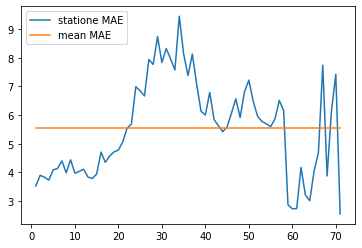

In [27]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

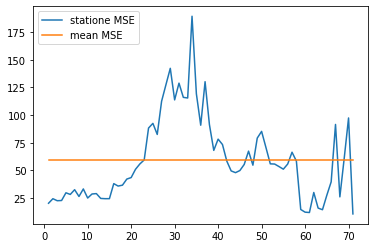

In [28]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [29]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  5.540480230895566
testing data MAE is  58.95546437653018


## loss = mse

In [8]:
class Transformer(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(120,72)
        self.layer2 = nn.Transformer(d_model=72, nhead=72)
    
    def forward(self, x):
        ouput = self.layer1(x[:,:120])
        ouput = self.layer2(ouput, x[:,120:]) 
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-2) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}


    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n0[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n0[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n0[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("Transformer Model_f", name="Transformer_120hr_MSE")
    model = Transformer() 
    trainer = pl.Trainer(max_epochs=1500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [9]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/Transformer Model_f/Transformer_120hr_MSE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

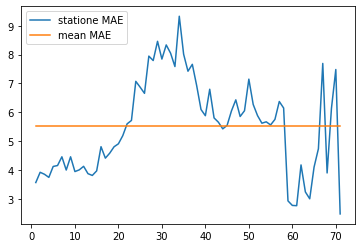

In [10]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

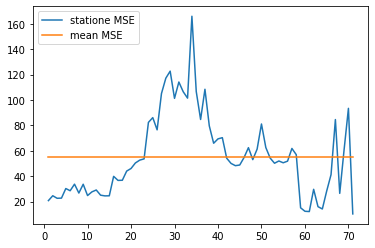

In [11]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [12]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  5.5123235709230665
testing data MAE is  55.26823540808449


## loss = Huber loss

In [ ]:
class Transformer(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(120,72)
        self.layer2 = nn.Transformer(d_model=72, nhead=72)
    
    def forward(self, x):
        ouput = self.layer1(x[:,:120])
        ouput = self.layer2(ouput, x[:,120:]) 
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-2) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=539 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}


    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n0[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n0[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n0[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("Transformer Model_f", name="Transformer_120hr_Huber")
    model = Transformer() 
    trainer = pl.Trainer(max_epochs=1500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [ ]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/Transformer Model_f/Transformer_120hr_Huber/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

In [ ]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

In [ ]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [ ]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))